In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.stats import zscore
import scipy.io
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna_Z_scores.csv"

"""Load the Z-score data frame """
df = pd.read_csv(fpath, index_col=0)
print(f"{df.shape=}")
df.head()

df.shape=(48, 20967)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
T0_R1,1.405404,1.354427,-0.350276,1.712226,-0.702826,-0.118115,-0.470459,1.108334,2.080126,0.176877,...,-0.550108,-0.502374,-0.971989,-0.494887,-1.431415,-0.642975,-2.125625,0.878478,-1.223717,-0.486207
T0_R2,1.039275,1.099166,0.086865,1.994941,-1.442005,1.298854,-0.470459,0.605171,0.948936,-0.060846,...,-0.648207,-0.549161,-0.830686,-0.571403,-0.355441,-0.649817,-1.159188,0.271296,0.179373,-0.310175
T0_R3,2.685915,1.322179,-0.840162,0.867014,-1.295536,0.041865,-0.470459,1.855671,2.331780,1.593111,...,-0.684741,-0.533209,-1.012156,-1.552568,-1.627332,-1.067803,-2.735546,1.435850,-1.810500,-1.022328
T1_R1,0.497787,1.699461,-0.979287,0.833893,0.598781,0.233814,-0.470459,0.042615,0.484603,-0.166841,...,0.038745,-0.135519,-0.922598,-1.298813,-0.747879,-1.036149,-0.334006,0.285189,-0.634321,-0.626263
T1_R2,1.506375,3.163352,0.129377,0.630835,-0.512408,0.441264,1.279210,-0.010344,1.225840,0.477273,...,0.031715,-0.181473,-1.030909,-0.676906,-0.935824,-0.723831,-0.332538,0.840669,-1.057363,-0.610950


In [18]:
""" get marker genes """

def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]        
    return genes['official gene symbol'].to_list()

""" Load the marker gene database """
pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pang_df = pd.read_csv(pdfPath, sep="\t")
pang_df.head()

""" UI """
U = 0.01

# xtract gene lists    
fbList = getGenes(pang_df, 'Fibroblasts', ui_upper=U)


mg_cells = ['Myoblasts', 'Myofibroblasts', 'Myocytes']
myList = []

for mg in mg_cells:
    myList += getGenes(pang_df, mg, ui_upper=U)

myList = list(set(myList))

print(f"{len(fbList)=} (raw)")
print(f"{len(myList)=} (raw)")

# filter for those in our data
genes = df.columns.to_list()
fbList = [x for x in fbList if x in genes]
myList = [x for x in myList if x in genes]
print()

print(f"{len(fbList)=} (filtered)")
print(f"{len(myList)=} (filtered)")

overlaps = list(set(fbList).intersection(myList))
print(f"{len(overlaps)=}")

len(fbList)=54 (raw)
len(myList)=64 (raw)

len(fbList)=47 (filtered)
len(myList)=60 (filtered)
len(overlaps)=2


In [12]:
# pdf = df.copy()

# rep = "R2"

# pdf = pdf[myList]
# pdf = pdf.reset_index(drop=False)
# pdf['time'] = pdf['index'].apply(lambda x: x.split("_")[0].replace("T", ""))
# pdf['replicate'] = pdf['index'].apply(lambda x: x.split("_")[1])

# pdf = pdf[pdf['replicate'] == rep]
# pdf = pdf.drop(columns=['replicate'])

# pdf = pd.melt(pdf, id_vars=['index', 'time'])

# sns.lineplot(data=pdf, 
#              x='time',
#              y='value',
#              hue='variable',
#              palette='viridis',
#              alpha=0.5,
#              legend=False)

# pdf.head()

len(set(clusters))=10


,cluster,gene
0,1,"[MYOZ1, ANKRD1, ADAM12, IL4]"
1,2,[MYF6]
2,3,[NPHS1]
3,4,[NPPA]
4,5,"[TNNC1, MYH7, MYOG, DOCK5, TNNT3, ACTN2, MYH8,..."
5,6,"[CAV3, TTN, ITGA7, CMKLR1, MUSK, ANKRD2, LIF, ..."
6,7,"[ACTN3, TNNC2, GATA4]"
7,8,"[TMOD4, PLD1, DLL1, THBS4, PRKCQ, NGF, NPPB, M..."
8,9,"[SIX4, LAMA2]"
9,10,"[NID2, MEF2D, ANGPT2]"


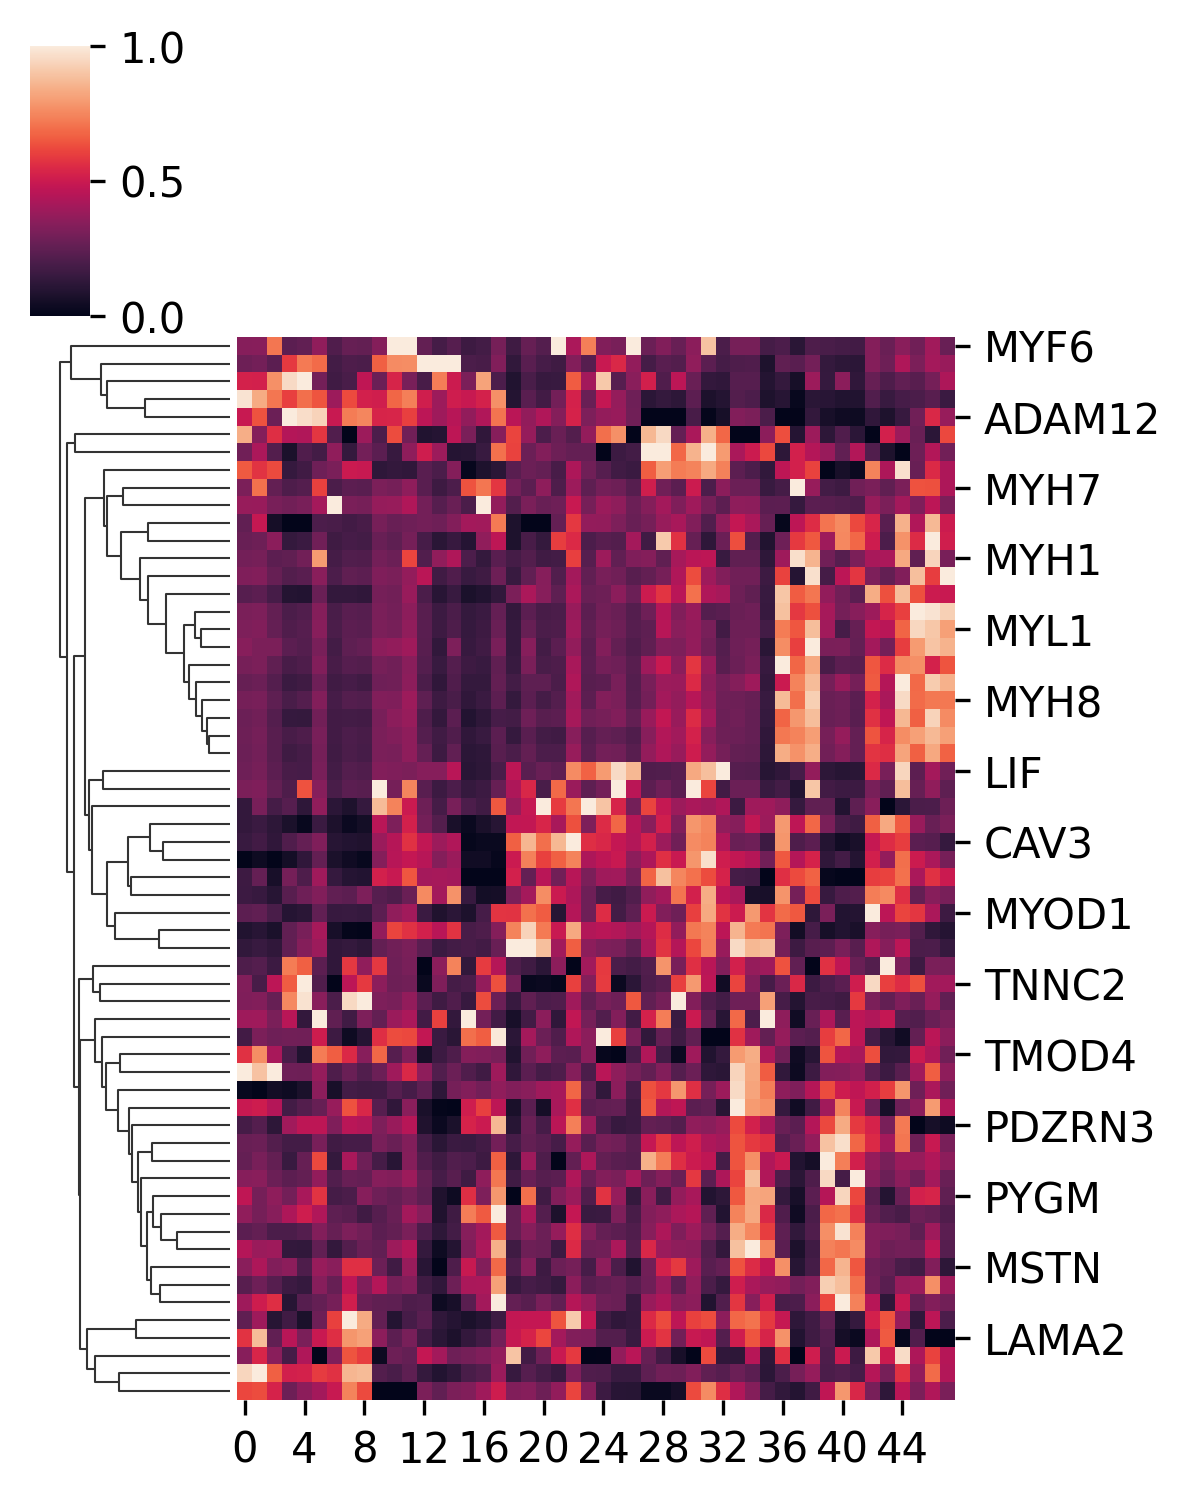

In [33]:
pdf = df.copy()

gene_list = myList

pdf = pdf[gene_list]
pdf = pdf.reset_index(drop=False)
pdf['time'] = pdf['index'].apply(lambda x: x.split("_")[0].replace("T", ""))
pdf['replicate'] = pdf['index'].apply(lambda x: x.split("_")[1])

plt.rcParams['figure.dpi'] = 300

p = sns.clustermap(data=pdf[gene_list].T,
               figsize=(4, 5),
               standard_scale=1,
               col_cluster=False,
              )

# sort the genes
linkage = p.dendrogram_row.linkage
# t = 2
t = 2

clusters = fcluster(linkage, criterion='distance', t=t)
print(f"{len(set(clusters))=}")


gene_cluster = pd.DataFrame({'gene' : gene_list, 
                             'cluster' : clusters})

gene_cluster = gene_cluster.groupby('cluster')['gene'].apply(list).reset_index(drop=False)
gene_cluster

# print(clusters)

['TNNC1', 'MYH7', 'MYOG', 'DOCK5', 'TNNT3', 'ACTN2', 'MYH8', 'MYH1', 'CKM', 'MYL1', 'ACTA1', 'MYLPF', 'TNNI1', 'TNNI2', 'PTGIR', 'GATA5', 'ZBTB16']


Text(0.5, 44.16666666666663, 'Time')

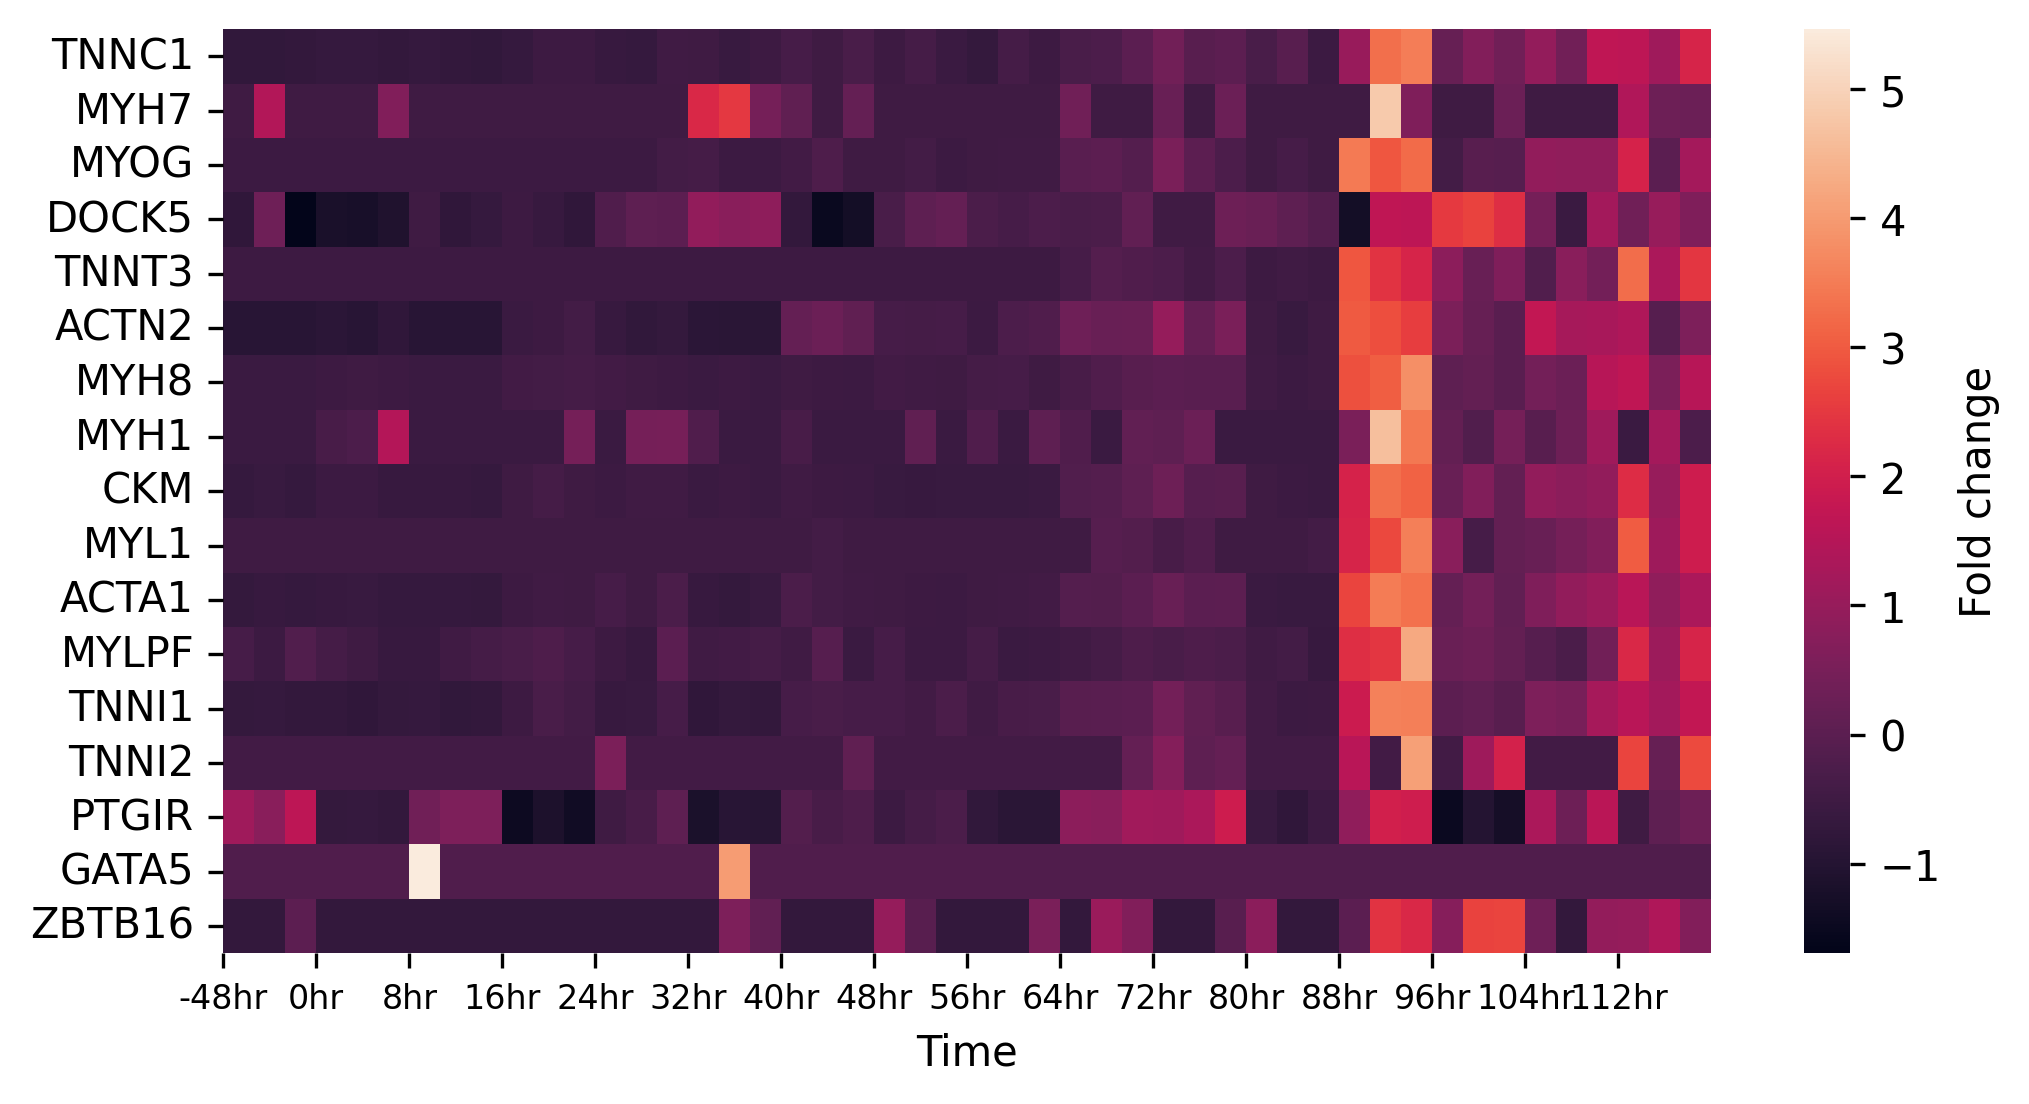

In [34]:
cluster = 5
cluster_genes = gene_cluster.loc[gene_cluster['cluster'] == cluster]['gene'].values[0]
print(cluster_genes)

# cluster_genes.remove("GATA5")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

sns.heatmap(data=pdf[cluster_genes].T,
            cbar_kws={'label': 'Fold change'})

xticks = list(range(0, 48, 3))
xtickLabels = np.array(range(-1, 15)) * 8 # hours between time points
# xtickLabels = xtickLabels  - 48 # hours offset

xtickLabels = [f"{x}hr" for x in xtickLabels]
xtickLabels[0] = "-48hr"


plt.xticks(xticks, xtickLabels, rotation=0, fontsize=8)
plt.xlabel("Time")

In [ ]:
linkage = p.dendrogram_row.linkage
t = 2.3

clusters = fcluster(linkage, criterion='distance', t=t)
print(f"{len(set(clusters))=}")


In [ ]:
list(dir(p.dendrogram_row))

In [ ]:


# sns.heamap(data=pdf[])